In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

import lightgbm as lgbm
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder


# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

# Load Data

In [2]:
df_raw = pd.read_csv('data/train_transaction.csv')
df_id = pd.read_csv('data/train_identity.csv')

In [3]:
print('Total number of transactions: {} \nTotal number of Frauds: {}' .format(len(df_raw), np.count_nonzero(df_raw.isFraud)))

Total number of transactions: 590540 
Total number of Frauds: 20663


In [4]:
df = pd.merge(df_raw, df_id, how = 'left', on = 'TransactionID')

In [5]:
df.drop('TransactionID', axis = 1, inplace = True)

In [6]:
del df_raw
del df_id

# Data Exploration

In [7]:
pd.options.display.max_columns = 394
df.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,...,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0

In [8]:
print('Amount Paid Total:')
df.TransactionAmt.describe().apply("{0:.2f}".format)

Amount Paid Total:


count    590540.00
mean        135.03
std         239.16
min           0.25
25%          43.32
50%          68.77
75%         125.00
max       31937.39
Name: TransactionAmt, dtype: object

In [9]:
print('Amount Paid Only Fraud:')
df.TransactionAmt[df.isFraud == 1].describe().apply("{0:.2f}".format)

Amount Paid Only Fraud:


count    20663.00
mean       149.24
std        232.21
min          0.29
25%         35.04
50%         75.00
75%        161.00
max       5191.00
Name: TransactionAmt, dtype: object

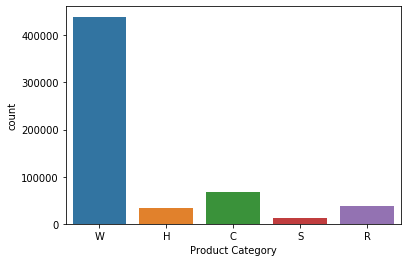

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(df.ProductCD, order = 'WHCSR');
plt.xlabel('Product Category');

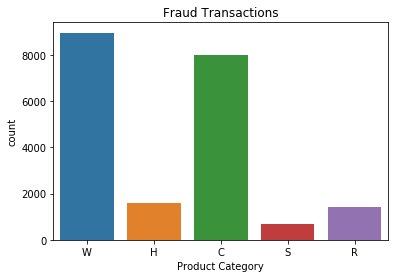

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(df.ProductCD[df.isFraud == 1], order = 'WHCSR');
plt.title('Fraud Transactions');
plt.xlabel('Product Category');

In [12]:
# Columns with the most percentage of missing values
null_vals = pd.DataFrame({'Null_Ratio': df.isnull().sum()/len(df)*100})
null_vals.sort_values(by = 'Null_Ratio', ascending = False, inplace = True)
null_vals.head(20)

,Null_Ratio
id_24,99.196159
id_25,99.130965
id_08,99.127070
id_07,99.127070
id_21,99.126393
id_26,99.125715
id_27,99.124699
id_23,99.124699
id_22,99.124699
dist2,93.628374


In [13]:
pd.value_counts(df.id_18, dropna=False, normalize= True)

NaN     0.923607
15.0    0.043162
13.0    0.022757
12.0    0.007884
18.0    0.001101
20.0    0.000574
17.0    0.000395
26.0    0.000151
21.0    0.000132
24.0    0.000088
11.0    0.000061
27.0    0.000054
29.0    0.000015
23.0    0.000007
14.0    0.000005
16.0    0.000002
25.0    0.000002
28.0    0.000002
10.0    0.000002
Name: id_18, dtype: float64

In [14]:
# Categorical columns
cat_cols = list(df.select_dtypes(include=['object']).columns)
df[cat_cols] = df[cat_cols].astype('category')
cat_cols

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'id_12',
 'id_15',
 'id_16',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'DeviceType',
 'DeviceInfo']

In [15]:
test_idx = int(len(df)*0.8)
valid_idx = int(len(df)*0.2)
df_train = df[0:test_idx]
df_test = df[test_idx:]

In [16]:
train_data = lgbm.Dataset(df_train[0:valid_idx].drop(['TransactionDT', 'isFraud'], axis = 1), label = df_train[0:valid_idx].isFraud)
valid_data = lgbm.Dataset(df_train[valid_idx:].drop(['TransactionDT', 'isFraud'], axis = 1), label = df_train[valid_idx:].isFraud)

In [17]:
params = {'num_leaves': 2**8,
          'min_child_weight': 0.03,
          'feature_fraction': 0.38,
          'bagging_fraction': 0.42,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.007,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.39,
          'reg_lambda': 0.65,
          'random_state': 42
         }

In [18]:
model = lgbm.train(params,train_data,500,valid_sets = [train_data, valid_data],verbose_eval=200,early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.974863	valid_1's auc: 0.877428
[400]	training's auc: 0.991011	valid_1's auc: 0.883412
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.995021	valid_1's auc: 0.884519


In [19]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),df_train.drop(['TransactionDT', 'isFraud'], axis = 1).columns), reverse=True), columns=["Value","Feature"])

In [20]:
feature_imp

,Value,Feature
0,8466,card1
1,7375,card2
2,6214,TransactionAmt
3,5713,addr1
4,3953,D15
...,...,...
426,0,V117
427,0,V116
428,0,V114
429,0,V113


Text(0.5, 1.0, 'Feature Importance')

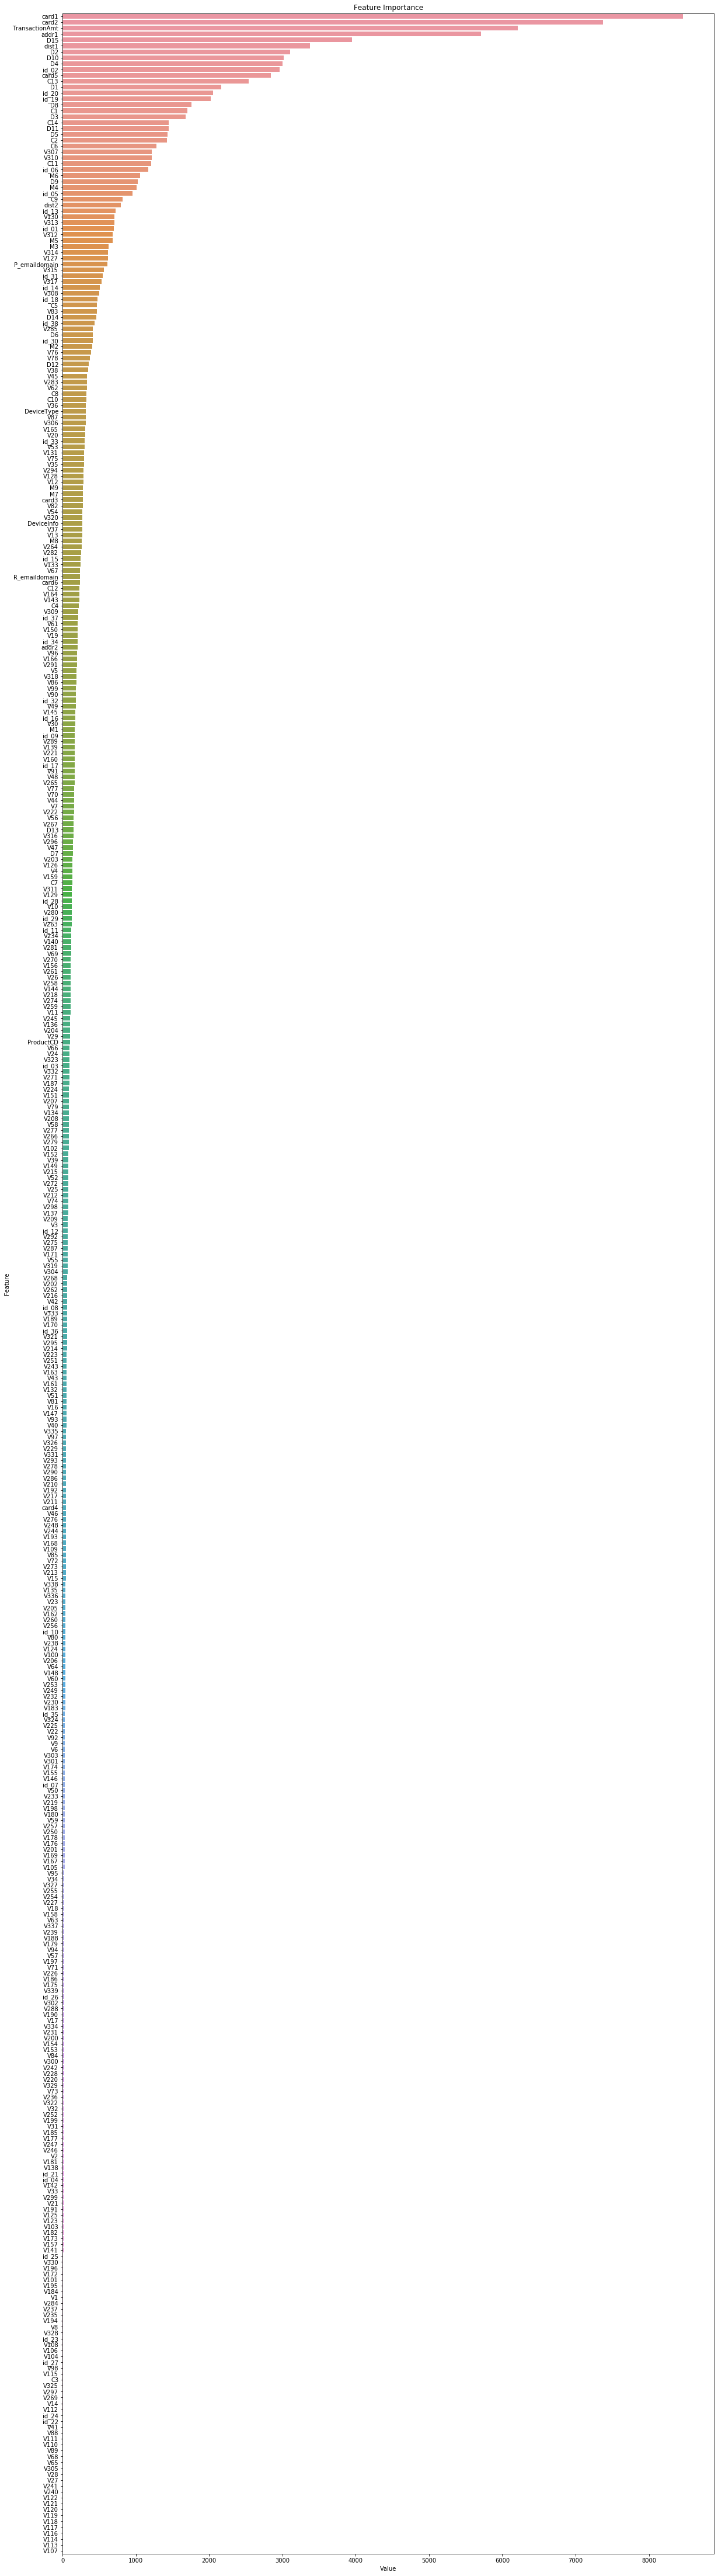

In [21]:
plt.figure(figsize = (20,80));
sns.barplot(data=feature_imp, x='Value', y='Feature');
plt.title('Feature Importance')

In [22]:
not_imp_features = feature_imp.Feature[[i for i in range(len(feature_imp)) if (feature_imp.Value[i] < 15) and (null_vals.loc[feature_imp.Feature[i]]>0.9).bool()]]
cat_cols = set(cat_cols)-set(not_imp_features)
not_imp_features

361     V247
362     V246
363       V2
364     V181
365     V138
366    id_21
367    id_04
368     V142
369      V33
371      V21
372     V191
376     V182
377     V173
378     V157
379     V141
380    id_25
381     V330
382     V196
383     V172
385     V195
386     V184
387       V1
389     V237
390     V235
391     V194
392       V8
393     V328
394    id_23
398    id_27
402     V325
404     V269
405      V14
407    id_24
408    id_22
409      V41
410      V88
413      V89
414      V68
415      V65
417      V28
418      V27
419     V241
420     V240
Name: Feature, dtype: object

# Pre-Processing

In [23]:
def feat_eng(df):
    startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
    df['TransactionDT'] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

    df['year'] = df['TransactionDT'].dt.year
    df['month'] = df['TransactionDT'].dt.month
    df['dow'] = df['TransactionDT'].dt.dayofweek
    df['hour'] = df['TransactionDT'].dt.hour
    df['day'] = df['TransactionDT'].dt.day
    df.drop('TransactionDT', axis = 1, inplace = True)

    for col in cat_cols:
        le = LabelEncoder()
        le.fit(list(df[col].astype(str).values))
        df[col] = le.transform(list(df[col].astype(str).values))

    return df

In [24]:
def preprocess(df):

    df.drop(not_imp_features, axis = 1, inplace = True)

    df = feat_eng(df)
    
    df.fillna(value = -999, inplace = True)

    return(df)

In [25]:
correlations = df_train.corr()['isFraud']

In [43]:
corr_df = pd.DataFrame({'isFraud': correlations.drop('isFraud', axis = 0)})

In [58]:
corr_df.sort_values(by = 'isFraud', ascending=False, inplace = True)

In [59]:
corr_df

,isFraud
V257,0.376922
V244,0.362693
V242,0.357924
V246,0.357095
V233,0.321014
...,...
V90,-0.111586
V48,-0.115531
id_01,-0.122579
D7,-0.138245


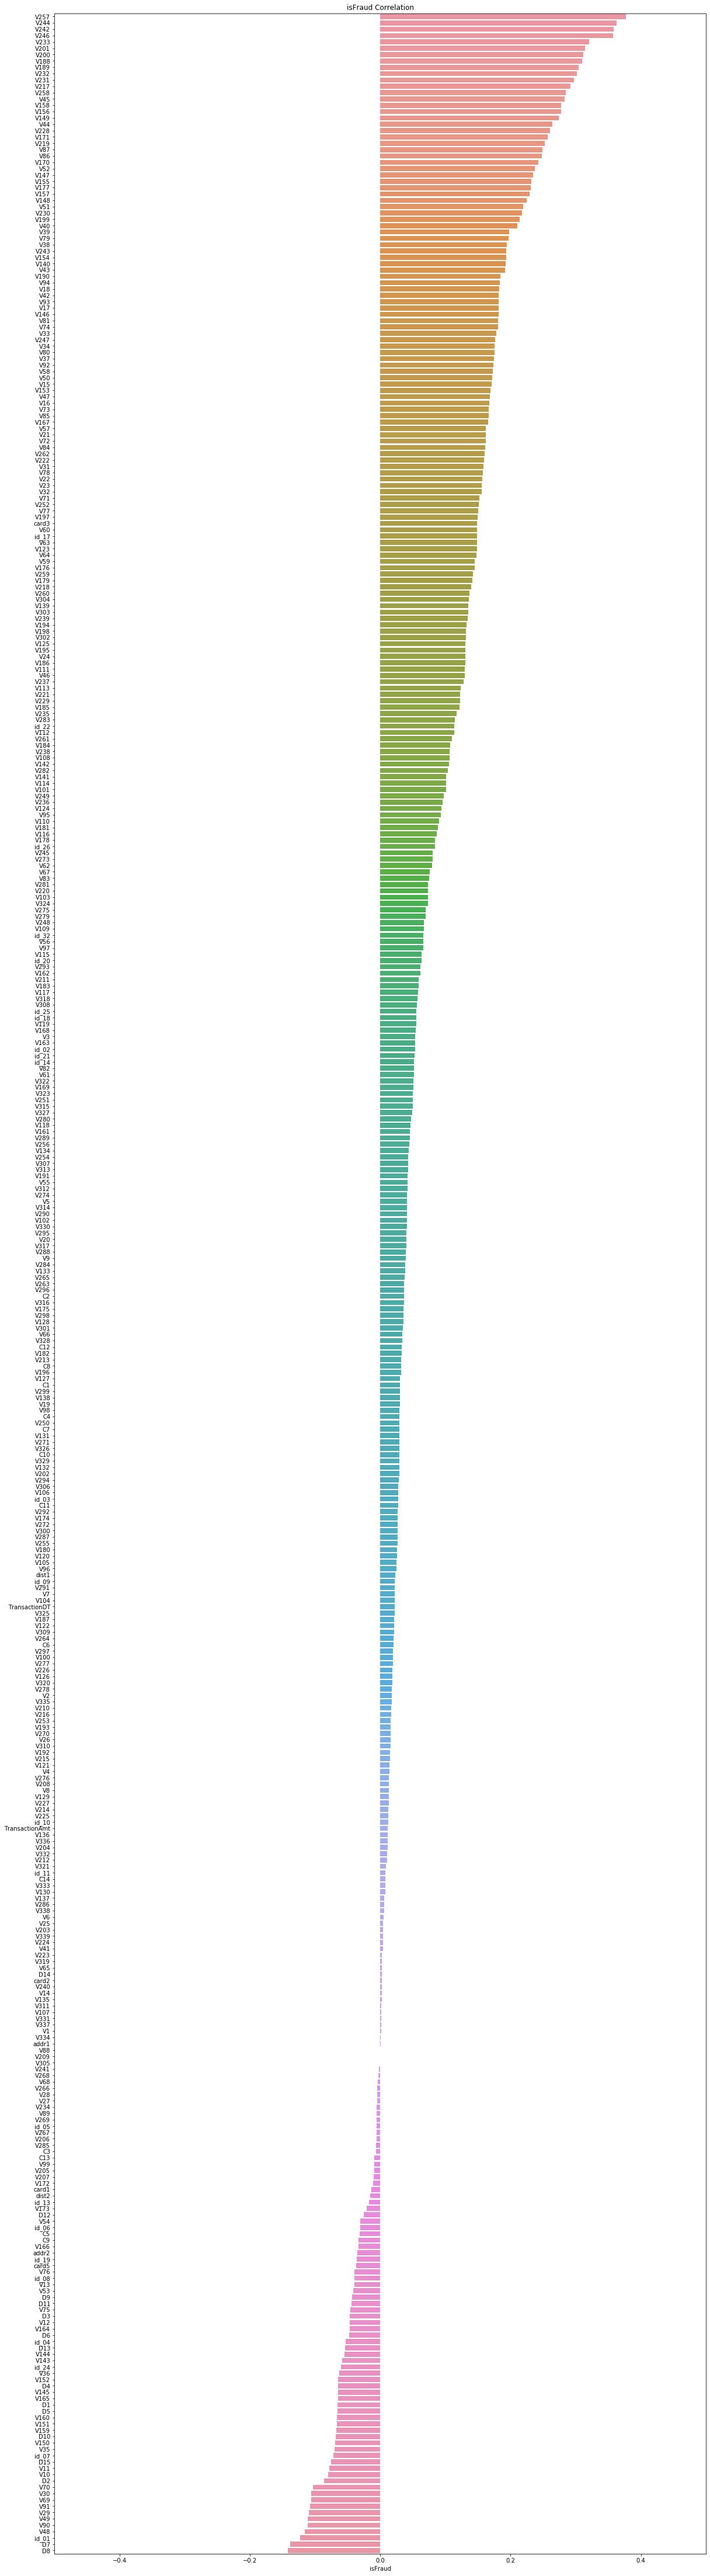

In [60]:
plt.figure(figsize = (20,80));
sns.barplot(data=corr_df, x='isFraud', y=corr_df.index);
plt.title('isFraud Correlation');
plt.xlim(-0.5,0.5);

In [181]:
df_train = preprocess(df_train)
df_test = preprocess(df_test)

# Modeling

In [182]:
X_train = df_train[0:valid_idx].drop('isFraud', axis = 1)
y_train = df_train.isFraud[0:valid_idx]

X_valid = df_train[valid_idx:].drop('isFraud', axis = 1)
y_valid = df_train.isFraud[valid_idx:]

In [183]:
# Weights

tot_num = len(y_train)
Fraud_num = np.count_nonzero(y_train)
nonFraud_num = tot_num- Fraud_num
weights = {0: 1/Fraud_num*tot_num/2, 1: 1/nonFraud_num*tot_num/2}

In [184]:
# Models in a dictionary
models = {"Logistic Regression": LogisticRegression(n_jobs = -1, random_state = 42, class_weight=weights),
          "KNN": KNeighborsClassifier(n_jobs = -1),
          "Random Forest": RandomForestClassifier(n_jobs = -1, random_state = 42, class_weight=weights)}

In [185]:
# Create a function to fit and score models
def fit_and_score(models, X_train, X_valid, y_train, y_valid):
    """
    Fits and evaluates given machine learning models.
    models : a dict of differetn Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_valid : validation data (no labels)
    y_train : training labels
    y_valid : validation labels
    """
    # Set random seed
    np.random.seed(42)
    # Make a dictionary to keep model scores
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        # Evaluate the model and append its score to model_scores
        model_scores[name] = model.score(X_valid, y_valid)
    return model_scores

In [186]:
#Compare the models on a part of the dataset
idx = 50000
model_scores = fit_and_score(models=models,
                             X_train=X_train[0:idx],
                             X_valid=X_valid[0:idx],
                             y_train=y_train[0:idx],
                             y_valid=y_valid[0:idx])

model_scores

{'Logistic Regression': 0.9637, 'KNN': 0.96074, 'Random Forest': 0.97132}

## Fit the whole data

In [191]:
X_train = df_train.drop('isFraud', axis = 1)
y_train = df_train.isFraud

In [196]:
model_rf = RandomForestClassifier(n_jobs = -1, random_state = 42, class_weight=weights)
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0: 20.8966737438075,
                                     1: 0.5122569004701514},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# Test Dataset

In [197]:
X_test = df_test.drop('isFraud', axis = 1)
y_test = df_test.isFraud

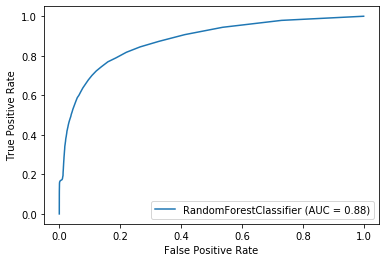

In [204]:
# Plot ROC curve and calculate and calculate AUC metric
plot_roc_curve(model_rf, X_test, y_test);

In [ ]:
# Make predictions with tuned model
y_preds = model_rf.predict(X_test)

In [ ]:
print(classification_report(y_test, y_preds))